In [5]:
!pip install numpy==1.26.4 pandas==2.1.3 statsmodels==0.14.5 pmdarima==2.0.4 scikit-learn==1.3.0
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 63.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 108.2 MB/s eta 0:00:00
  Created wheel for scikit-learn: filename=scikit_learn-1.3.0-cp312-cp312-linux_x86_64.whl size=10672935 sha256=fee34b377227a9bbeaf7b0cb07af1d5ef0a1a98aab39ebc88ada50b63b6af110
  Stored in directory: /root/.cache/pip/wheels/dc/e7/56/cae51184980f4c0f7bc63c40ccecad85060b79f19452e19b14
Successfully built scikit-learn
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Un

In [3]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.1 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cargando datos históricos desde: /content/drive/MyDrive/Tesis/CACIC/Interpolación/precios_cemento_interpolado.csv
--- Datos Históricos Cargados ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 139 entries, 2014-01-01 to 2025-07-01
Freq: MS
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Precio_Cemento  139 non-null    float64
 1   Nivel_Rio       139 non-null    float64
 2   Cuarentena      139 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 4.3 KB
None


Cargando exógenas futuras desde: /content/drive/MyDrive/Tesis/CACIC/Interpolación/promedio_mensual_nivel_predicho.csv
--- Exógenas Futuras Preparadas ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2025-07-01 to 2027-06-01
Freq: MS
Data columns (total 2 columns):
 #   Column      Non-Nul

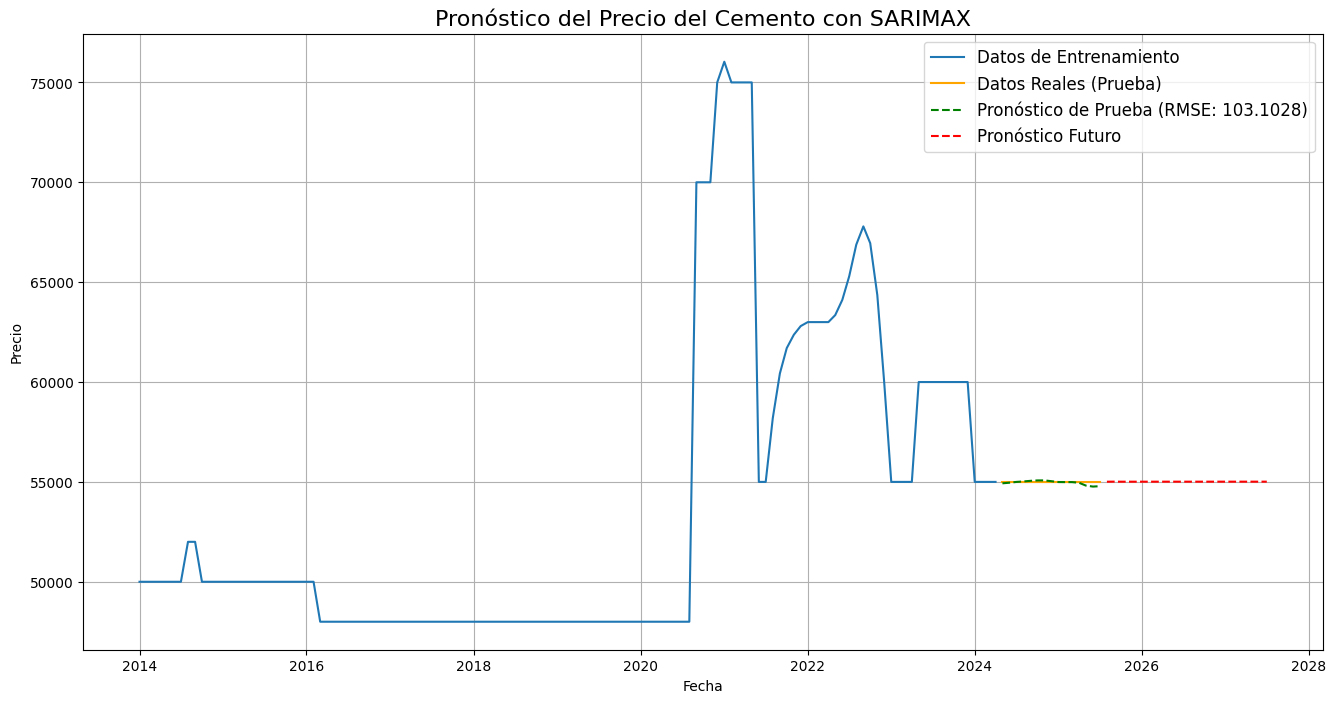

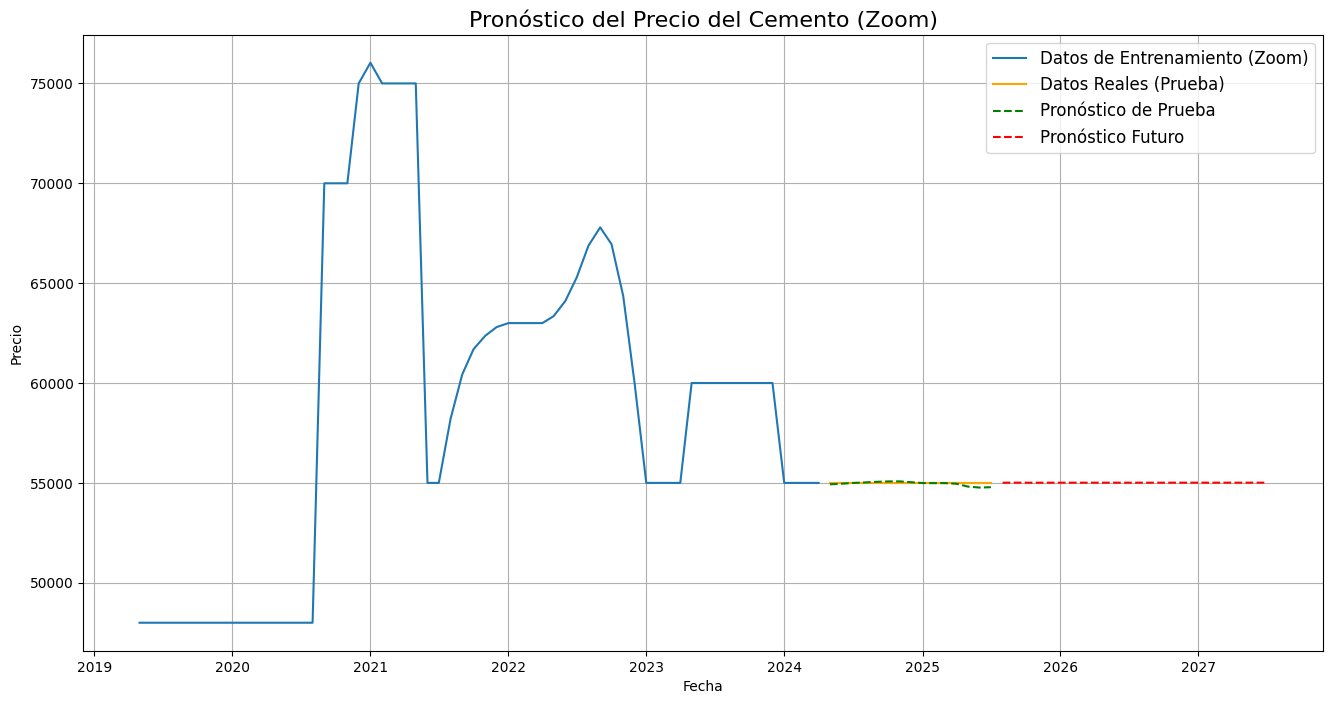

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
# --- ¡NUEVA IMPORTACIÓN! ---
from sklearn.metrics import mean_squared_error
import warnings

# Ignorar advertencias comunes
warnings.filterwarnings("ignore")

# --- 0. Montar Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Definir Rutas de Archivos ---
ruta_base = '/content/drive/MyDrive/Tesis/CACIC/Interpolación/'
ruta_archivo_principal = ruta_base + 'precios_cemento_interpolado.csv'
ruta_archivo_nivel_rio = ruta_base + 'promedio_mensual_nivel_predicho.csv'

# --- 1. Carga y Preparación de Datos HISTÓRICOS ---
# (Esta sección es idéntica a la tuya, la incluyo para que el script sea completo)
print(f"Cargando datos históricos desde: {ruta_archivo_principal}")
df_hist = pd.read_csv(
    ruta_archivo_principal,
    index_col='Fecha',
    parse_dates=True,
    decimal=','
)
df_hist = df_hist.rename(columns={
    'Precio_Promedio_Polinomial_2': 'Precio_Cemento',
    'Cuarentena_Covid': 'Cuarentena',
    'Nivel': 'Nivel_Rio'
})
df_hist['Precio_Cemento'] = df_hist['Precio_Cemento'].astype(str).str.replace(',', '.').astype(float)
df_hist['Nivel_Rio'] = df_hist['Nivel_Rio'].astype(str).str.replace(',', '.').astype(float)
df_hist['Cuarentena'] = pd.to_numeric(df_hist['Cuarentena'])
df_hist = df_hist[['Precio_Cemento', 'Nivel_Rio', 'Cuarentena']]
df_hist = df_hist.asfreq('MS')
# if df_hist.isnull().sum().any():
#     print("Manejando NaNs en datos históricos (ffill)...")
#     df_hist = df_hist.fillna(method='ffill')
print("--- Datos Históricos Cargados ---")
print(df_hist.info())
print("\n")


# --- 2. Carga y Preparación de Datos FUTUROS (Exógenas) ---
# (Esta sección también es idéntica)
print(f"Cargando exógenas futuras desde: {ruta_archivo_nivel_rio}")
df_future_exog = pd.read_csv(
    ruta_archivo_nivel_rio,
    index_col='Fecha',
    parse_dates=True,
    decimal=','
)
df_future_exog = df_future_exog.rename(columns={'Nivel': 'Nivel_Rio'})
df_future_exog['Nivel_Rio'] = df_future_exog['Nivel_Rio'].astype(str).str.replace(',', '.').astype(float)
df_future_exog = df_future_exog.asfreq('MS')
df_future_exog['Cuarentena'] = 0 # Asumimos 0 para el futuro
df_future_exog = df_future_exog[['Nivel_Rio', 'Cuarentena']]
print("--- Exógenas Futuras Preparadas ---")
print(df_future_exog.info())
print("\n")


# --- 3. Definición de Variables y Análisis Exploratorio ---

endogena_Y = df_hist['Precio_Cemento']
exogenas_X = df_hist[['Nivel_Rio', 'Cuarentena']]

print("Descomponiendo la serie del precio del cemento...")
# (El gráfico de descomposición se omite aquí por brevedad, pero tu código original está bien)
# ... decomposition.plot() ...


# --- 3.5. ¡NUEVO! División en Entrenamiento (Train) y Prueba (Test) ---

n_test = 15
print(f"Dividiendo los datos: {n_test} meses para prueba, {len(endogena_Y) - n_test} meses para entrenamiento.")

# Dividimos la variable endógena (Precio Cemento)
Y_train = endogena_Y.iloc[:-n_test]
Y_test = endogena_Y.iloc[-n_test:]

# Dividimos las variables exógenas (Nivel Rio, Cuarentena)
X_train = exogenas_X.iloc[:-n_test]
X_test = exogenas_X.iloc[-n_test:]

print(f"Forma Y_train: {Y_train.shape} | Forma Y_test: {Y_test.shape}")
print(f"Forma X_train: {X_train.shape} | Forma X_test: {X_test.shape}")
print("\n")


# --- 4. Búsqueda de Parámetros con Auto-ARIMA (SOBRE DATOS TRAIN) ---

print("Buscando los mejores parámetros con auto_arima (sobre datos de TRAIN)...")
auto_arima_model = auto_arima(
    Y_train,              # <--- ¡MODIFICADO!
    exogenous=X_train,    # <--- ¡MODIFICADO!
    seasonal=True,
    m=15,
    stepwise=True,
    suppress_warnings=True,
    trace=True
)

print("\n--- Resultados de Auto-ARIMA ---")
print(auto_arima_model.summary())

best_order = auto_arima_model.order
best_seasonal_order = auto_arima_model.seasonal_order


# --- 5. Entrenamiento del Modelo de VALIDACIÓN (SOBRE DATOS TRAIN) ---

print(f"\nEntrenando modelo de validación con order={best_order} y seasonal_order={best_seasonal_order}...")

# Entrenamos solo con el set de TRAIN para poder validar contra TEST
model_train = SARIMAX(
    Y_train,
    exog=X_train,
    order=best_order,
    seasonal_order=best_seasonal_order
)

res_train = model_train.fit(disp=False)

print("\n--- Resumen del Modelo (Entrenado en Train) ---")
print(res_train.summary())


# --- 6. ¡NUEVO! Validación y Cálculo de RMSE ---

print(f"\nGenerando predicción de prueba de {n_test} meses...")

# Predecimos el período de TEST usando las exógenas de TEST
test_forecast = res_train.predict(
    start=Y_test.index[0], # O start=len(Y_train)
    end=Y_test.index[-1],  # O end=len(Y_train) + n_test - 1
    exog=X_test,
    typ='levels' # 'levels' da la predicción en la escala original
)

test_forecast = test_forecast.rename('Pronóstico de Prueba')

# Calcular el RMSE
rmse = np.sqrt(mean_squared_error(Y_test, test_forecast))
print("\n--- MÉTRICA DE VALIDACIÓN ---")
print(f"RMSE en el conjunto de prueba: {rmse:.4f}")
print("------------------------------\n")


# --- 7. ¡NUEVO! Re-entrenamiento del Modelo FINAL (con TODOS los datos) ---

print(f"Re-entrenando modelo FINAL con TODOS los datos (order={best_order}, seasonal_order={best_seasonal_order})...")

# Es la mejor práctica: encontramos parámetros en TRAIN, validamos en TEST,
# y para el pronóstico final, re-entrenamos con TODOS los datos históricos.
final_model = SARIMAX(
    endogena_Y, # <--- ¡TODOS LOS DATOS Y!
    exog=exogenas_X, # <--- ¡TODOS LOS DATOS X!
    order=best_order,
    seasonal_order=best_seasonal_order
)

final_res = final_model.fit(disp=False)

print("\n--- Resumen del Modelo Final (Todos los datos) ---")
print(final_res.summary())


# --- 8. Pronóstico del Precio del Cemento (FUTURO) ---

n_futuro = len(df_future_exog)
print(f"\nGenerando pronóstico de {n_futuro} meses...")

# Usamos el modelo final (final_res) para predecir el futuro
forecast_cemento = final_res.predict(
    start=len(endogena_Y), # Inicia justo después del último dato histórico
    end=len(endogena_Y) + n_futuro - 1,
    exog=df_future_exog, # ¡Usa las exógenas futuras!
    typ='levels'
)

forecast_cemento = forecast_cemento.rename('Pronóstico Futuro')

print("\n--- Valores del Pronóstico Futuro ---")
print(forecast_cemento)


# --- 9. Visualización del Resultado Final (Mejorada) ---

print("Mostrando gráfico del pronóstico...")

plt.figure(figsize=(16, 8))
plt.plot(Y_train, label='Datos de Entrenamiento')
plt.plot(Y_test, label='Datos Reales (Prueba)', color='orange')
plt.plot(test_forecast, label=f'Pronóstico de Prueba (RMSE: {rmse:.4f})', linestyle='--', color='green')
plt.plot(forecast_cemento, label='Pronóstico Futuro', linestyle='--', color='red')

plt.title('Pronóstico del Precio del Cemento con SARIMAX', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Gráfico de Zoom
plt.figure(figsize=(16, 8))
# Mostramos los últimos 60 puntos de TRAIN + todo el TEST y FUTURO
plt.plot(Y_train.iloc[-60:], label='Datos de Entrenamiento (Zoom)')
plt.plot(Y_test, label='Datos Reales (Prueba)', color='orange')
plt.plot(test_forecast, label='Pronóstico de Prueba', linestyle='--', color='green')
plt.plot(forecast_cemento, label='Pronóstico Futuro', linestyle='--', color='red')

plt.title('Pronóstico del Precio del Cemento (Zoom)', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend(fontsize=12)
plt.grid(True)
plt.show()